## Application

### Environment Setup
- Defining the computational resource for implementing this project. (Not to Use GPU)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

### Library Imports

* Pandas and NumPy : for structured data manipulation and managing the dataset arrays
* Contractions and Strings : for implementing document nomalization such as removing special characters and noise
* Tensorflow and Scikit-learn : for design and training classification models like Multinomial Naive Bayes(MNB) and Bi-LSTM
* Scikit-learn : for implmenting MNB and calculating Accuracy, F1-Score, Classification Metrics and Confusion Matrix
* Matplotlib, WordCloud and Seaborn : for generating data exploration plots and model evaludation heatmaps

In [2]:
from datasets import load_dataset
import pandas as pd
import contractions
import string
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, RocCurveDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

2026-01-18 13:06:40.900140: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-18 13:06:41.196236: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-18 13:06:42.527858: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/rooneyish/Applied_Machine_Learning/News_Article_Classification/.venv/lib/python3.11/s

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rooneyish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/rooneyish/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/rooneyish/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/rooneyish/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2026-01-18 13:06:44.364411: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-01-18 13:06:44.364464: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:160] env: CUDA_VISIBLE_DEVICES="-1"
2026-01-18 13:06:44.364471: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2026-01-18 13:06:44.364479: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2026-01-18 13:06:44.364483: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: rooneyish
2026-01-18 13:06:44.364487: I external/local_xla/xla/stream_executor/cuda/cud

### Loading Dataset

In [5]:
ds = load_dataset("sh0416/ag_news")

In [6]:
# Concatinating into single DataFrame
df = pd.concat([ds['train'].to_pandas(), ds['test'].to_pandas()])

In [7]:
df.head(5)

,label,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   label        127600 non-null  int64 
 1   title        127600 non-null  object
 2   description  127600 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.9+ MB


In [9]:
df.shape

(127600, 3)

In [10]:
df.isnull().sum()

label          0
title          0
description    0
dtype: int64

### Data Pre-Processing & Normalization

In [11]:
df.dropna(inplace = True)

In [12]:
df.duplicated().sum()

np.int64(0)

In [13]:
df.drop_duplicates(inplace = True)

In [14]:
df = df.drop('title', axis = 1) # removing title of the article
df.sample(5)

,label,description
82755,2,"Detroit, MI (Sports Network) - The Detroit Tig..."
21391,4,Yahoo has said that it would soon begin testin...
10516,1,Walking Barry Bonds intentionally to load the ...
98838,4,"Nintendo, the reigning champ of portable gamin..."
20291,2,Back-to-back drubbings at the hands of the Fev...


In [15]:
df = df.rename(columns={'label': 'y', 'description': 'X'})
df.head()

,y,X
0,3,"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Reuters - Private investment firm Carlyle Grou...
2,3,Reuters - Soaring crude prices plus worries\ab...
3,3,Reuters - Authorities have halted oil export\f...
4,3,"AFP - Tearaway world oil prices, toppling reco..."


In [16]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [17]:
news_publishers = ['reuters', 'afp', 'ap', 'associated press', 'reuters news', 'bloomberg', 'cbc sports online']

# Attempt 1
# def normalize_document(document):
#     document = document.lower() # lowercase the texts
#     document = contractions.fix(document) # converting don't --> do not 
#     document = document.translate(str.maketrans('','',string.punctuation)) # removing special characters
#     for publisher in news_publishers: # removing names of the news article publishers from the document
#         document = document.replace(publisher, '')
#     document = " ".join(document.split()) # removing whitespaces from the documents
#     return document

# Attempt 2 - Removing Stopwords and Lemmatization of Remaining words
def normalize_document(document):
    document = document.lower() # lowercase the texts
    document = contractions.fix(document) # converting don't --> do not 
    document = document.translate(str.maketrans('','',string.punctuation)) # removing special characters
    for publisher in news_publishers: # removing names of the news article publishers from the document
        document = document.replace(publisher, '')

    tokens = document.split() # Splitting to Tokens for Stop Words Removal and Lemmatization
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words] # Removing stopwords and lemmatization of remainin words
    document = " ".join(cleaned_tokens)
    return document

In [18]:
df['X'] = df['X'].apply(normalize_document)

In [19]:
df.head(5)

,y,X
0,3,shortsellers wall street dwindlingband ultracy...
1,3,private investment firm carlyle groupwhich rep...
2,3,soaring crude price plus worriesabout economy ...
3,3,authority halted oil exportflows main pipeline...
4,3,tearaway world oil price toppling record strai...


The document is now cleaned and normalized.

## Exploratory Data Analysis

### Class Imbalance Check

Checking if the dataset contains imbalanced classes. 

Text(0.5, 1.0, 'News Categories by No. of samples')

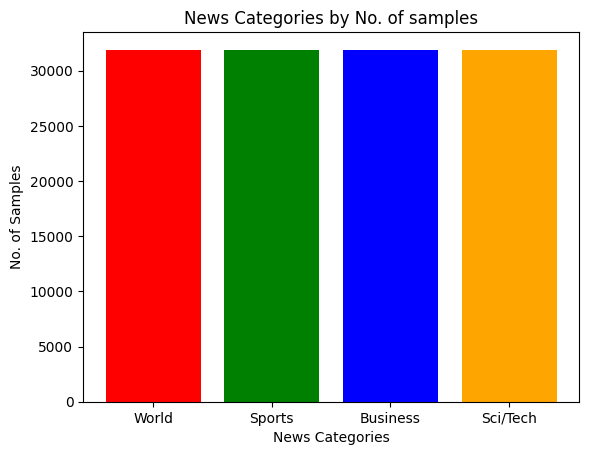

In [20]:
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

plt.bar(class_names, df['y'].value_counts().sort_index(), color = ['red', 'green', 'blue', 'orange'])
plt.ylabel('No. of Samples')
plt.xlabel('News Categories')
plt.title('News Categories by No. of samples')

### Word Cloud Analysis by Categories

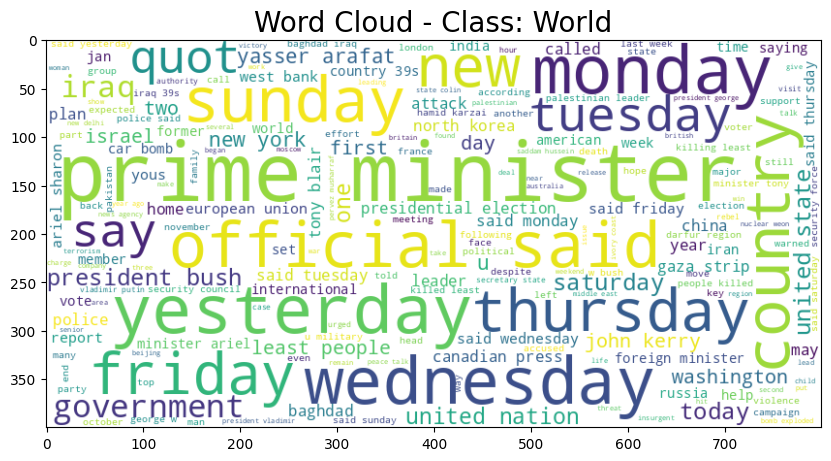

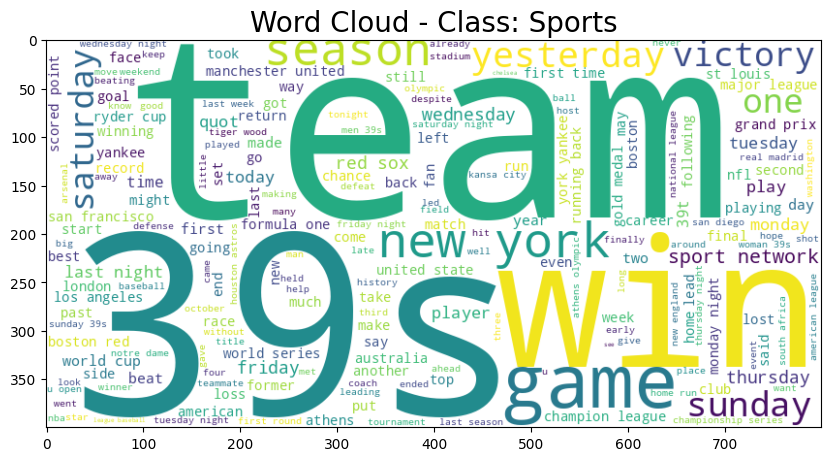

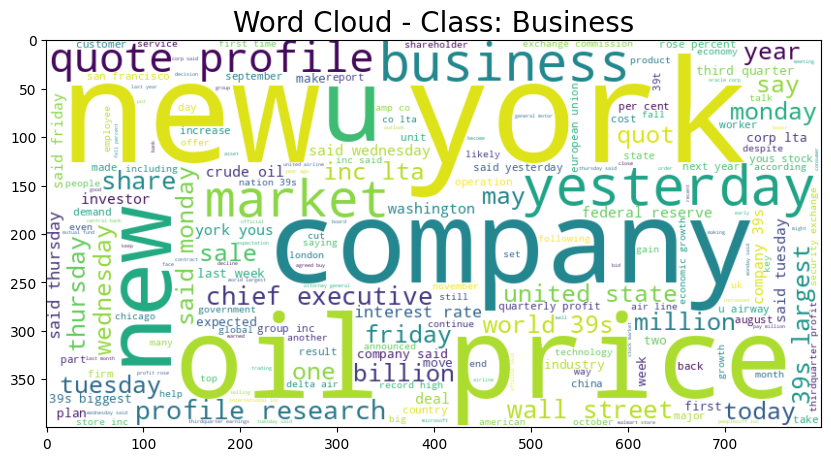

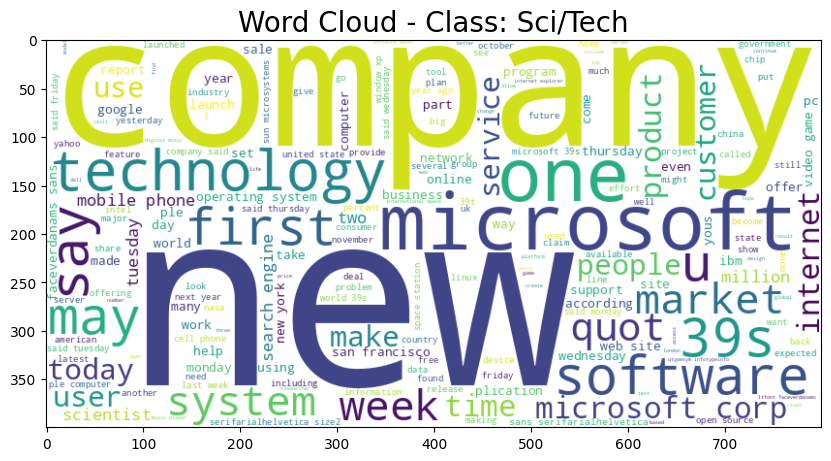

In [21]:
classes = sorted(df['y'].unique())

for category in classes:
    text_data = " ".join(df[df['y'] == category]['X'].astype(str))
        
    wc = WordCloud(
        width=800,
        height= 400,
        background_color='white',
        stopwords=set(STOPWORDS)
    ).generate(text_data)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    label_idx = int(category)-1
    plt.title(f'Word Cloud - Class: {class_names[label_idx]}', fontsize=20)

#### Business
The Business Category in this News Article Dataset is heavily centered around corporate entities.
The most dominant terms in this categories are:
* oil
* price
* new york
* company

#### Sci/Tech
Science and Technology category highlights the major factors and platfroms in the digital landscape.
The dominant keywords in this class are:
* software
* microsoft
* technology
* company
* internet

#### World
This class in the dataset is dominated mostly by geopolitical conflicts and international leadership.
Most Dominant Terms presented are:
* Iraq
* prime minster
* killed
* government

#### Sports
The Sports category reflects a focus on copetition resuls and major leagues.
Dominant Keywords are:
* win
* game
* team
* season
* victory

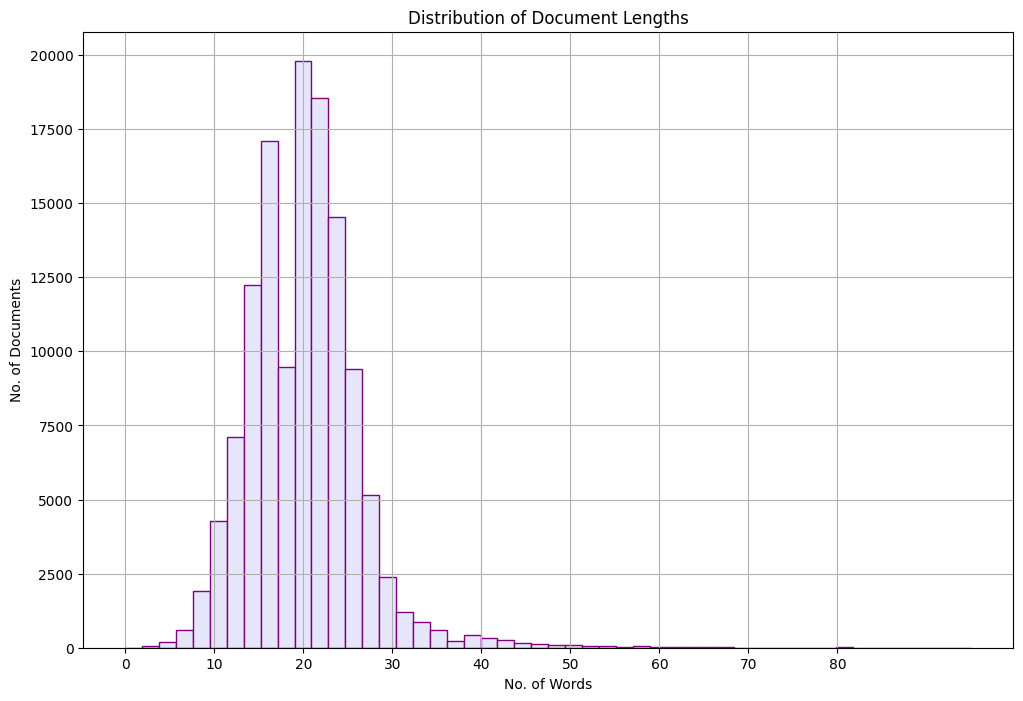

In [22]:
df['len_document'] = df['X'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12,8))
plt.hist(df['len_document'], bins=50, color='lavender', edgecolor = "purple")
plt.xticks(range(0, 90, 10))
plt.xlabel("No. of Words")
plt.ylabel("No. of Documents")
plt.title("Distribution of Document Lengths")
plt.grid(True)

## Train, Validation & Test Split

Splitting the DataFrame into 3 three parts for Training, Cross Validation and Testing. \
Train: 60% \
Validation: 20% \
Test: 30% 

In [23]:
# Attempt 1
X_train, X_temp, y_train, y_temp = train_test_split(df['X'], df['y'], test_size=0.3, random_state=42, stratify=df['y'])

# Attempt 2
# X_train, X_temp, y_train, y_temp = train_test_split(df['X'], df['y'], test_size=0.4, random_state=42, stratify=df['y'])
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [24]:
X_train.shape, X_val.shape, X_test.shape

((89320,), (19140,), (19140,))

## Feature Extraction

### Multinomial Naive Bayes - Feature Extraction

#### Implementing TF-IDF Vectorization for Multinomial Naive Bayes

In [25]:
tfidf = TfidfVectorizer()

In [26]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

In [27]:
tfidf.get_feature_names_out()[:20]

array(['00', '000', '000660se', '000th', '0013', '0013hk', '002', '004',
       '005', '005930ks', '007', '007percent', '008', '008s', '009', '01',
       '010', '0100', '011', '01102004'], dtype=object)

In [28]:
tfidf.vocabulary_

{'sudan': 63619,
 'decided': 20314,
 'postpone': 50865,
 'decision': 20326,
 'expel': 25153,
 'head': 31181,
 'two': 68683,
 'british': 13897,
 'aid': 7593,
 'agency': 7430,
 'oxfam': 48274,
 'save': 58294,
 'child': 16220,
 'citing': 16596,
 'administrative': 7049,
 'difficulty': 21348,
 'humanitarian': 33308,
 'ground': 30052,
 'cell': 15625,
 'phone': 49750,
 'manufacturer': 41055,
 'teaming': 65351,
 'bring': 13869,
 'mobile': 43163,
 'television': 65559,
 'handset': 30735,
 'although': 8325,
 'united': 69497,
 'state': 62608,
 'experiencing': 25168,
 'shortage': 60107,
 'flu': 26943,
 'vaccine': 70330,
 'fall': 25577,
 'eager': 22945,
 'one': 47159,
 'duped': 22774,
 'purchasing': 52315,
 'online': 47278,
 'corporate': 18603,
 'raider': 54629,
 'vincent': 70904,
 'bollor': 13159,
 'said': 57844,
 'yesterday': 73738,
 'raised': 54674,
 'stake': 62460,
 'french': 27822,
 'advertising': 7180,
 'group': 30069,
 'havas': 31085,
 '202': 1959,
 'alain': 7756,
 'de': 20150,
 'pouzilhac': 

### Bi-LSTM - Feature Extraction

#### Implementing Keras Tokenizer for Tokenization & GloVe Embedding for Vectorization

In [29]:
y_train_dl = y_train- 1
y_val_dl = y_val - 1
y_test_dl = y_test - 1

In [30]:
# Loading GloVe 
glove_path = 'glove.6B.100d.txt'

def load_embeddings(glove_path):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_embeddings(glove_path)

In [31]:
max_words = 20000
max_len = 100

In [32]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [33]:
embedding_dim = 100
word_index = tokenizer.word_index
word_index

{'39s': 1,
 'said': 2,
 'new': 3,
 'year': 4,
 'company': 5,
 'u': 6,
 'two': 7,
 'first': 8,
 'monday': 9,
 'world': 10,
 'tuesday': 11,
 'wednesday': 12,
 'thursday': 13,
 'inc': 14,
 'one': 15,
 'friday': 16,
 'week': 17,
 'yesterday': 18,
 'state': 19,
 'last': 20,
 'york': 21,
 'game': 22,
 'president': 23,
 'million': 24,
 'yous': 25,
 'corp': 26,
 'say': 27,
 'time': 28,
 'would': 29,
 'price': 30,
 'day': 31,
 'sunday': 32,
 'oil': 33,
 'united': 34,
 'group': 35,
 'official': 36,
 'government': 37,
 'people': 38,
 'today': 39,
 'service': 40,
 'could': 41,
 'three': 42,
 'security': 43,
 'team': 44,
 'quot': 45,
 'month': 46,
 'iraq': 47,
 'saturday': 48,
 'plan': 49,
 'percent': 50,
 'night': 51,
 'software': 52,
 'next': 53,
 'minister': 54,
 'second': 55,
 'market': 56,
 'season': 57,
 'country': 58,
 'announced': 59,
 'report': 60,
 'business': 61,
 'microsoft': 62,
 'computer': 63,
 'international': 64,
 'internet': 65,
 'may': 66,
 'washington': 67,
 'american': 68,
 'st

In [34]:
num_words = min(max_words, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Model Training

### Multinomial Naive Bayes

In [35]:
# Attempt 1
MNB_model = MultinomialNB(alpha=1.0) # Intializing Model
MNB_model.fit(X_train_tfidf,y_train) # Training Model
#-----------------------------------------------------------#
# Attempt 2
# MNB_model = MultinomialNB(alpha=2.0) # Intializing Model
# MNB_model.fit(X_train_tfidf,y_train) # Training Model
#-----------------------------------------------------------#
# Attempt 3
# MNB_model = MultinomialNB(alpha=3.0) # Intializing Model
# MNB_model.fit(X_train_tfidf,y_train) # Training Model

,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None


### Bi-LSTM 

In [36]:
# Defining Bi-LSTM Model
# Attempt 1
# LSTM_model = Sequential([       
#     Input(shape=(num_words,)),
#     Embedding(num_words, 
#               embedding_dim, 
#               weights=[embedding_matrix], 
#               trainable=False), 
#     Bidirectional(LSTM(64)),
#     Dropout(0.3),
#     Dense(32, activation='relu'),
#     Dense(4, activation='softmax') 
# ])

# Attempt 2 
LSTM_model = Sequential([       
    Input(shape=(num_words,)),
    Embedding(num_words, 
              embedding_dim, 
              weights=[embedding_matrix], 
              trainable=False), 
    Bidirectional(LSTM(64)),
    Dropout(0.35),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax') 
])

In [37]:
#Attempt 3 
# optimizer = Adam(learning_rate = 0.01)
# LSTM_model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
#--------------------------------------------------------------------------------------------------------------------#

# #Attempt 2 
# optimizer = Adam(learning_rate = 0.0001)
# LSTM_model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# #--------------------------------------------------------------------------------------------------------------------#

# Attempt 1 - with Learning Rate = 0.001
LSTM_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

LSTM_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20000, 100)     │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,088,740 (7.97 MB)

 Trainable params: 88,740 (346.64 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [38]:
history = LSTM_model.fit(X_train_pad, y_train_dl, epochs=10, batch_size=64, 
                    validation_data=(X_val_pad, y_val_dl))

Epoch 1/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.8650 - loss: 0.3892 - val_accuracy: 0.8881 - val_loss: 0.3270
Epoch 2/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.8893 - loss: 0.3185 - val_accuracy: 0.8952 - val_loss: 0.3058
Epoch 3/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - accuracy: 0.8966 - loss: 0.2958 - val_accuracy: 0.8966 - val_loss: 0.2975
Epoch 4/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.9023 - loss: 0.2787 - val_accuracy: 0.9013 - val_loss: 0.2905
Epoch 5/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.9067 - loss: 0.2668 - val_accuracy: 0.9032 - val_loss: 0.2814
Epoch 6/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - accuracy: 0.9116 - loss: 0.2537 - val_accuracy: 0.9026 - val_loss: 0.2817
Epoch 7/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - accuracy: 0.9152 - loss: 0.2429 - val_accuracy: 0.9051 - val_loss: 0.2787
Epoch 8/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - accuracy: 0.9186 -

## Model Evaluation

### Multinomial Naive Bayes

In [39]:
y_test_binarized = label_binarize(y_test_dl, classes=[0,1,2,3])

y_train_pred_MNB = MNB_model.predict(X_train_tfidf)
y_val_pred_MNB = MNB_model.predict(X_val_tfidf)
y_test_pred_MNB = MNB_model.predict(X_test_tfidf)
y_test_score_MNB = MNB_model.predict_proba(X_test_tfidf)

In [40]:
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

Evaluation - Multinomial Naive Bayes
Train Accuracy: 91.32%
Validation Accuracy: 89.73%
Test Accuracy: 89.73% 

Train F1 Score: 0.91
Validation F1 Score: 0.90
Test F1 Score: 0.90 

              precision    recall  f1-score   support

       World     0.9057    0.8951    0.9004      4785
      Sports     0.9478    0.9758    0.9616      4785
    Business     0.8612    0.8637    0.8625      4785
    Sci/Tech     0.8728    0.8548    0.8637      4785

    accuracy                         0.8973     19140
   macro avg     0.8969    0.8973    0.8970     19140
weighted avg     0.8969    0.8973    0.8970     19140



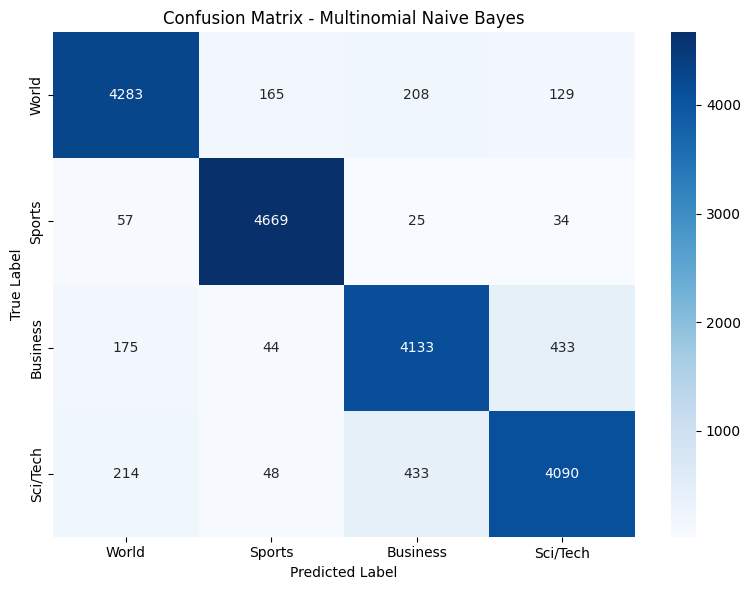

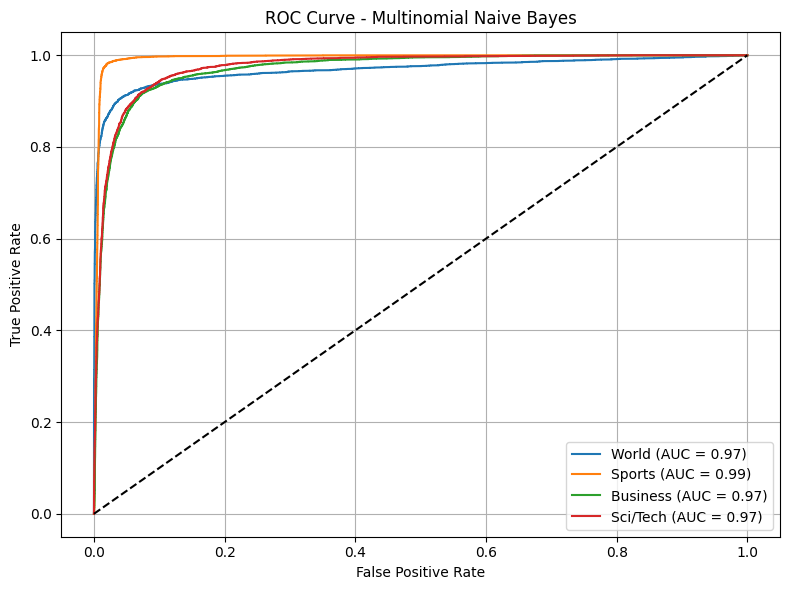

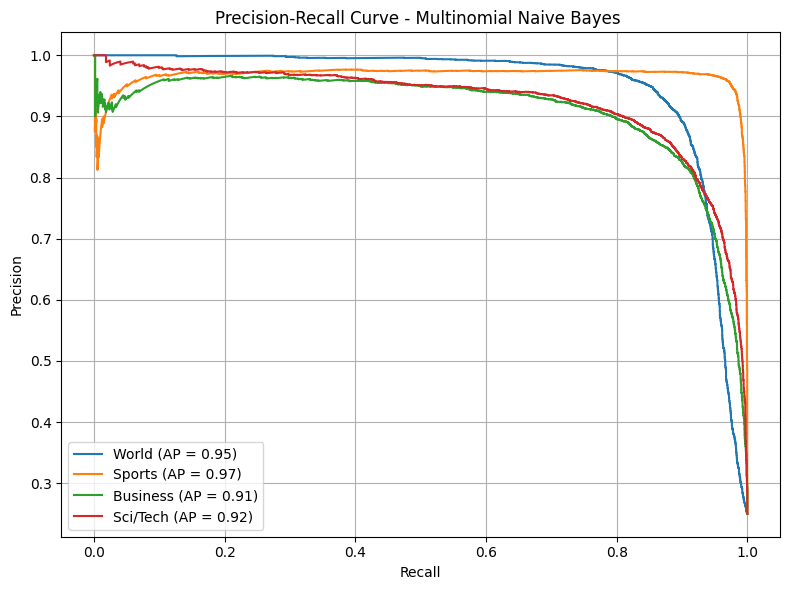

In [41]:
train_accuracy_MNB = accuracy_score(y_train, y_train_pred_MNB)
train_f1_score_MNB = f1_score(y_train, y_train_pred_MNB, average='weighted')

val_accuracy_MNB = accuracy_score(y_val, y_val_pred_MNB)
val_f1_score_MNB = f1_score(y_val, y_val_pred_MNB, average='weighted')

test_accuracy_MNB = accuracy_score(y_test, y_test_pred_MNB)
test_f1_score_MNB = f1_score(y_test, y_test_pred_MNB, average='weighted')

print(f"Evaluation - Multinomial Naive Bayes")
print(f"Train Accuracy: {train_accuracy_MNB*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy_MNB*100:.2f}%")
print(f"Test Accuracy: {test_accuracy_MNB*100:.2f}% \n")
print(f"Train F1 Score: {train_f1_score_MNB:.2f}")
print(f"Validation F1 Score: {val_f1_score_MNB:.2f}")
print(f"Test F1 Score: {test_f1_score_MNB:.2f} \n")


print(classification_report(y_test,y_test_pred_MNB, target_names=class_names, digits=4))

cm_MNB = confusion_matrix(y_test, y_test_pred_MNB)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_MNB,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(
        y_test_binarized[:, i],
        y_test_score_MNB[:, i]
    )
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        label=f"{class_names[i]} (AUC = {roc_auc:.2f})"
    )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multinomial Naive Bayes")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))

for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(
        y_test_binarized[:, i],
        y_test_score_MNB[:, i]
    )
    
    avg_precision = average_precision_score(
        y_test_binarized[:, i],
        y_test_score_MNB[:, i]
    )
    
    plt.plot(
        recall,
        precision,
        label=f"{class_names[i]} (AP = {avg_precision:.2f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Multinomial Naive Bayes ")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

### Bi-LSTM

In [42]:
y_train_pred_LSTM = LSTM_model.predict(X_train_pad)
y_val_pred_LSTM = LSTM_model.predict(X_val_pad)
y_test_pred_LSTM = LSTM_model.predict(X_test_pad)

2792/2792 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step
599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step


Evaluation - Bi-LSTM
Train Accuracy: 93.50%
Validation Accuracy: 90.41%
Test Accuracy: 90.24% 

Train F1 Score: 0.94
Validation F1 Score: 0.90
Test F1 Score: 0.90 

              precision    recall  f1-score   support

       World     0.9140    0.9018    0.9078      4785
      Sports     0.9643    0.9597    0.9620      4785
    Business     0.8879    0.8441    0.8654      4785
    Sci/Tech     0.8469    0.9041    0.8746      4785

    accuracy                         0.9024     19140
   macro avg     0.9033    0.9024    0.9025     19140
weighted avg     0.9033    0.9024    0.9025     19140



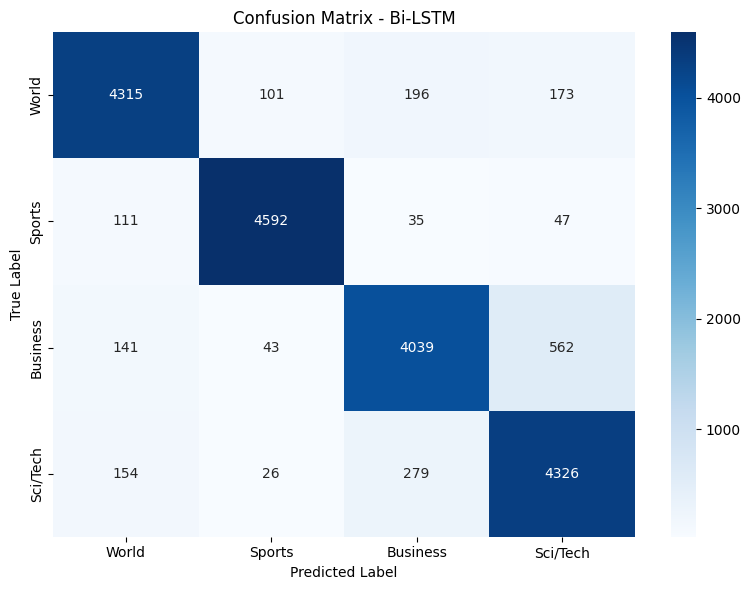

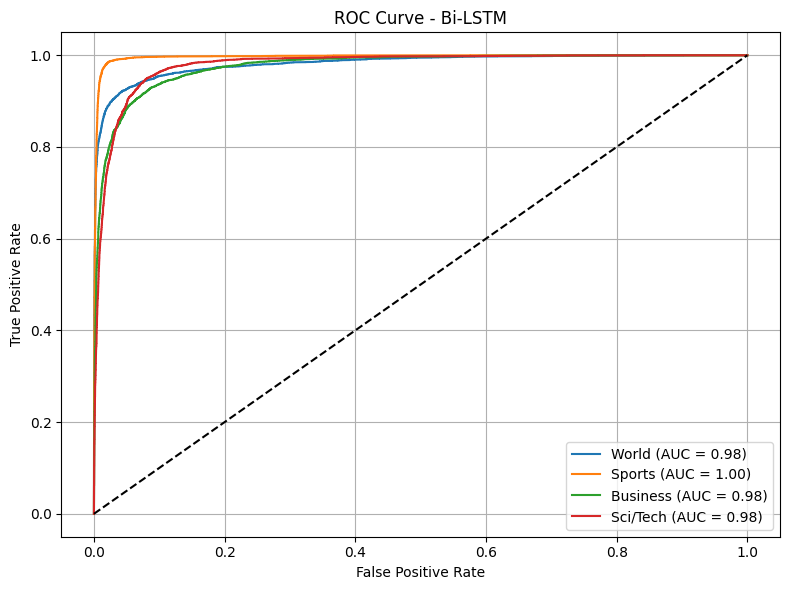

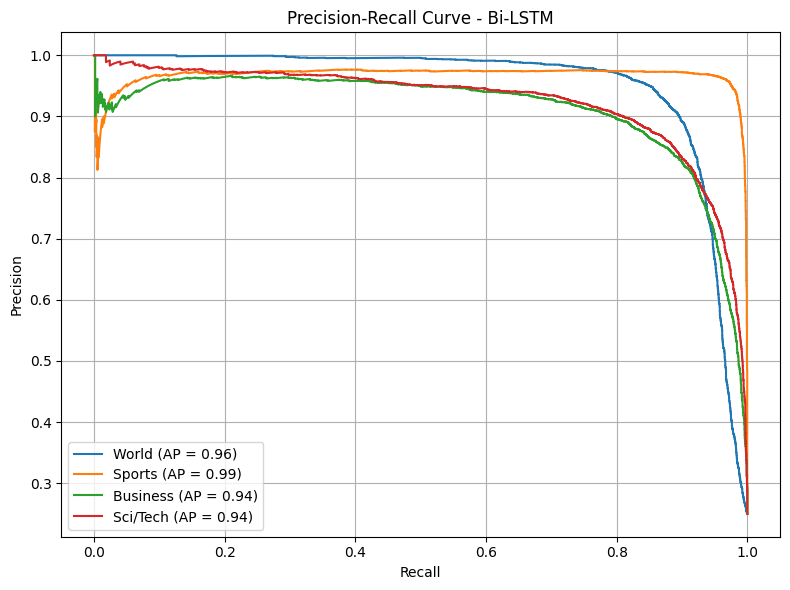

In [43]:
train_accuracy_LSTM = accuracy_score(y_train_dl, np.argmax(y_train_pred_LSTM, axis = 1))
train_f1_score_LSTM = f1_score(y_train_dl, np.argmax(y_train_pred_LSTM, axis = 1), average='weighted')
val_accuracy_LSTM = accuracy_score(y_val_dl, np.argmax(y_val_pred_LSTM, axis = 1))
val_f1_score_LSTM = f1_score(y_val_dl, np.argmax(y_val_pred_LSTM, axis = 1), average='weighted')
test_accuracy_LSTM = accuracy_score(y_test_dl, np.argmax(y_test_pred_LSTM, axis = 1))
test_f1_score_LSTM = f1_score(y_test_dl, np.argmax(y_test_pred_LSTM, axis = 1), average='weighted')


print(f"Evaluation - Bi-LSTM")
print(f"Train Accuracy: {train_accuracy_LSTM*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy_LSTM*100:.2f}%")
print(f"Test Accuracy: {test_accuracy_LSTM*100:.2f}% \n")
print(f"Train F1 Score: {train_f1_score_LSTM:.2f}")
print(f"Validation F1 Score: {val_f1_score_LSTM:.2f}")
print(f"Test F1 Score: {test_f1_score_LSTM:.2f} \n")

print(classification_report(y_test_dl,np.argmax(y_test_pred_LSTM, axis = 1), target_names=class_names, digits=4))

cm_LSTM = confusion_matrix(y_test_dl, np.argmax(y_test_pred_LSTM, axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_LSTM,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Bi-LSTM")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(
        y_test_binarized[:, i],
        y_test_pred_LSTM[:, i]
    )
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        label=f"{class_names[i]} (AUC = {roc_auc:.2f})"
    )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Bi-LSTM")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))

for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(
        y_test_binarized[:, i],
        y_test_score_MNB[:, i]
    )
    
    avg_precision = average_precision_score(
        y_test_binarized[:, i],
        y_test_pred_LSTM[:, i]
    )
    
    plt.plot(
        recall,
        precision,
        label=f"{class_names[i]} (AP = {avg_precision:.2f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Bi-LSTM")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

## Prediction on Unseen Samples

In [59]:
class_names_LSTM = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
class_names_MNB = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}
def predict_news(text):
    cleaned_text = normalize_document(text)

    text_tfidf = tfidf.transform([cleaned_text])
    predict_MNB_idx = MNB_model.predict(text_tfidf)[0]
    mnb_categorized = class_names_MNB[predict_MNB_idx]

    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded_seq = pad_sequences(seq, maxlen=100)
    predict_LSTM = LSTM_model.predict(padded_seq)
    predict_LSTM_idx = np.argmax(predict_LSTM)
    lstm_categorized = class_names_LSTM[predict_LSTM_idx]

    print(f"Input News: \n {text} \n")
    print('Models Classications: ')
    print(f"MNB Prediction:    {mnb_categorized}")
    print(f"Bi-LSTM Prediction: {lstm_categorized}")

predict_text = """
Blue aliens, a family of superheroes and a city of talking animals boosted the Walt Disney Company
 to the top of the domestic box office in 2025.

Full-year ticket sales in the United States and Canada rose about 4% from 2024 to $9.05 billion. Disney accounted for the highest share of that haul with $2.49 billion in ticket sales, or 27.5%, according to data from Comscore.

It’s closest competitors were Warner Bros. Discovery
, which tallied $1.9 billion domestically, or 21%, and Universal
, which took in $1.7 billion, or 19.7%. Together, these three studios accounted for nearly 70% of the domestic box office market share."""
predict_news(predict_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Input News: 
 
Blue aliens, a family of superheroes and a city of talking animals boosted the Walt Disney Company
 to the top of the domestic box office in 2025.

Full-year ticket sales in the United States and Canada rose about 4% from 2024 to $9.05 billion. Disney accounted for the highest share of that haul with $2.49 billion in ticket sales, or 27.5%, according to data from Comscore.

It’s closest competitors were Warner Bros. Discovery
, which tallied $1.9 billion domestically, or 21%, and Universal
, which took in $1.7 billion, or 19.7%. Together, these three studios accounted for nearly 70% of the domestic box office market share. 

Models Classications: 
MNB Prediction:    Business
Bi-LSTM Prediction: Business
